In [12]:
"""Test data preprocessing."""

import os
import pytest
import numpy as np
from data.gestures import linear_accelerometer
from iotai_sensor_classification.recording import read_recordings
from iotai_sensor_classification.preprocess import parse_recording, SAMPLES_PER_RECORDING, check_windows
from iotai_sensor_classification.plot_util import plot_lines
import pandas as pd

In [13]:
def gesture_recordings():
    """Read gesture recordings for all tests in file."""
    recordings_dir = os.path.dirname(linear_accelerometer.__file__)
    recordings = read_recordings(recordings_dir=recordings_dir)
    return recordings

gesture_recordings_ = gesture_recordings()

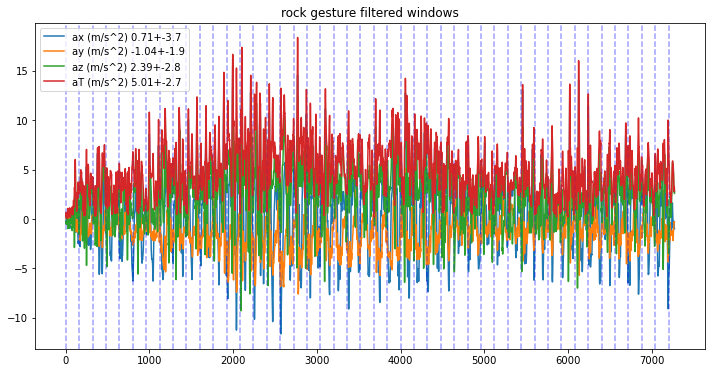

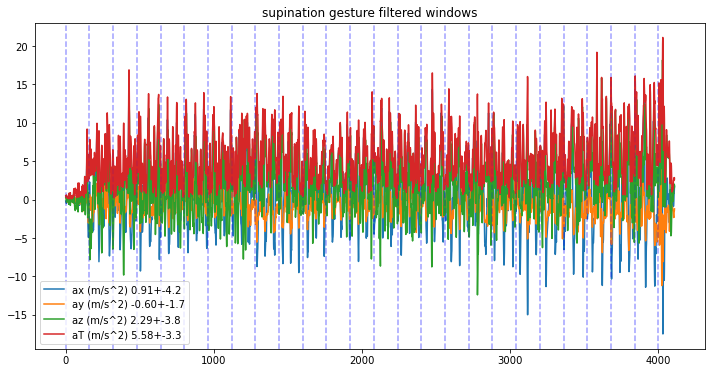

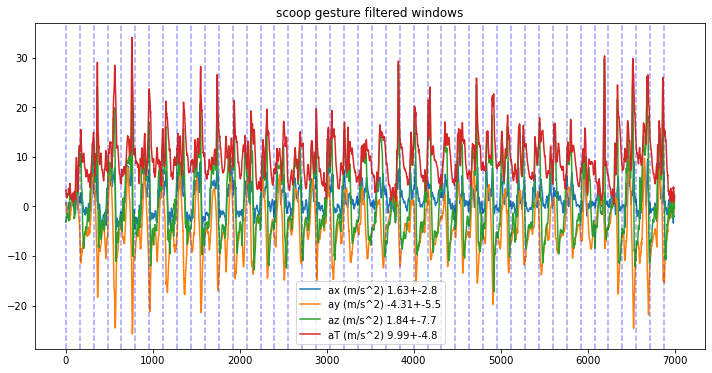

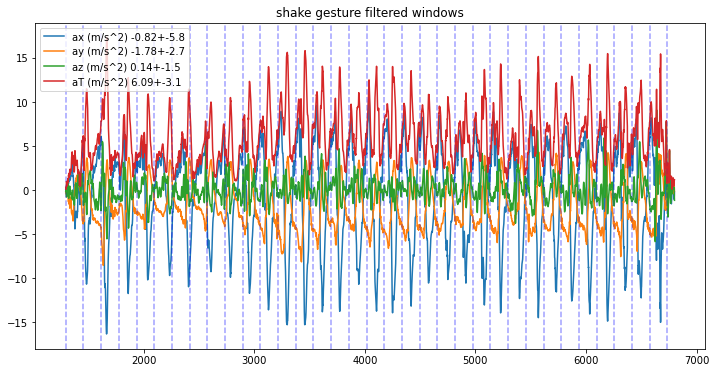

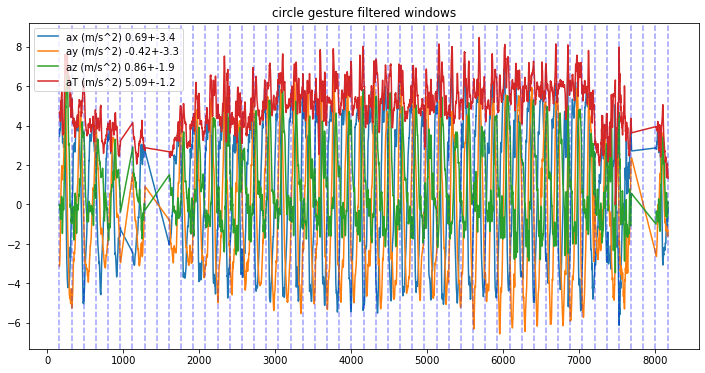

In [14]:
# def test_parse_gestures(gesture_recordings):
#     """Test parsing gesture data creating labels into a dataset for training and or testing models."""
window_checked = check_windows(gesture_recordings_)
test_output = os.path.join("test_output", "gestures", "preprocessed")
os.makedirs(test_output, exist_ok=True)
for label_name in window_checked.keys():
    label_data = window_checked[label_name]
    plot_lines(label_data, name=f"{label_name} gesture filtered windows", vertical_tick_spacing=SAMPLES_PER_RECORDING)
normed_gesture_measures, encoded_labels, label_coder = parse_recording(window_checked, samples_per_recording=SAMPLES_PER_RECORDING)
n_col_measures = normed_gesture_measures.shape[2]
col_measure_means = [normed_gesture_measures[:, :, col].mean() for col in range(n_col_measures)]
col_measure_stds = [normed_gesture_measures[:, :, col].std() for col in range(n_col_measures)]
# normalization is done on all measures. Extra measurements not fitting in a sample window are dropped causing mean
# and standard deviation to drift from mean=0 and std=1
assert all(np.isclose(col_measure_means, 0.0, atol=0.02))
assert all(np.isclose(col_measure_stds, 1.0, atol=0.01))
gesture_names = label_coder.decode_one_hots(encoded_labels)
gesture_recording_n = pd.Series(gesture_names).value_counts()
gesture_names_of_recs = gesture_recording_n.keys()
for rec_name in gesture_names_of_recs:
    read_rec = gesture_recordings_[rec_name]
    n_read = int(read_rec.shape[0]/SAMPLES_PER_RECORDING)
    # windows dropped in check
    assert gesture_recording_n[rec_name] <= n_read